In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

In [2]:
%%javascript 
var kernel = Jupyter.notebook.kernel; 
var command = ["notebookName = ",
               "'", window.document.body.dataset.notebookName, "'" ].join('')
kernel.execute(command)

<IPython.core.display.Javascript object>

In [3]:
import os
import sys
file_dir = os.path.dirname(os.path.abspath(notebookName))
sys.path.append(os.path.abspath(os.path.join(
    file_dir, os.pardir, os.pardir, 'scripts')))

In [ ]:
# run cell for interactive plots
import mpld3
mpld3.enable_notebook()

In [4]:
from reldresal import load_log

In [5]:
from enum import Enum
ExctType = Enum('ExctType', ['upper', 'lower'])
ExctFreq = Enum('ExctFreq', ['f0', 'f1', 'f2'])
import collections
Record = collections.namedtuple('Record', ['exct_type', 'exct_freq', 'data'])

# load data files
records = []
records.append(Record(ExctType.lower, ExctFreq.f0, load_log('t_lower_f0.log.gz')))
records.append(Record(ExctType.lower, ExctFreq.f1, load_log('t_lower_f1.log.gz')))
records.append(Record(ExctType.lower, ExctFreq.f2, load_log('t_lower_f2.log.gz')))
records.append(Record(ExctType.upper, ExctFreq.f0, load_log('t_upper_f0.log.gz')))
records.append(Record(ExctType.upper, ExctFreq.f1, load_log('t_upper_f1.log.gz')))
records.append(Record(ExctType.upper, ExctFreq.f2, load_log('t_upper_f2.log.gz')))

In [6]:
from phobos.constants import sa

def convert_adc_nm(record):
    torque_adc = record.data.kistler_torque_adc
    t_neg_mask = (torque_adc > sa.KISTLER_ADC_ZERO_OFFSET_NEGATIVE).astype(int)
    t_pos_mask = (torque_adc < sa.KISTLER_ADC_ZERO_OFFSET_POSITIVE).astype(int)
    t_neg = (t_neg_mask *
             (sa.MAX_KISTLER_TORQUE_NEGATIVE/sa.ADC_HALF_RANGE) *
             (torque_adc - sa.KISTLER_ADC_ZERO_OFFSET_NEGATIVE))
    t_pos = (t_pos_mask *
             (sa.MAX_KISTLER_TORQUE_POSITIVE/sa.ADC_HALF_RANGE) *
             (torque_adc - sa.KISTLER_ADC_ZERO_OFFSET_POSITIVE))
    torque = t_neg + t_pos
    if record.exct_type == ExctType.upper:
        # need to negate sensor torque reading
        return -torque
    return torque

def plot_data(record, show_plot=True):
    colors = sns.color_palette('Paired', 10)
    fig, ax = plt.subplots(2, 1, figsize=(11, 6), sharex=True)
    
    steer_angle = record.data.steer_angle
    kistler_torque = convert_adc_nm(record)
    #kistler_torque = scipy.signal.medfilt(
    #    convert_adc_nm(record.data.kistler_torque_adc),
    #    3)

    ax[0].plot(record.data.time, steer_angle,
               color=colors[1], label='steer angle')
    ax[0].plot(record.data.time, 0*record.data.time,
               color='black', linewidth=1, zorder=1)
    ax[0].legend()
    ax[0].set_xlabel('time [s]')
    ax[0].set_ylabel('[rad]')

    ax[1].plot(record.data.time, kistler_torque, color=colors[3],
               alpha=0.8, label='sensor torque')
    ax[1].plot(record.data.time, 0*record.data.time, color='black', linewidth=1, zorder=1)
    ax[1].legend()
    ax[1].set_xlabel('time [s]')
    ax[1].set_ylabel('torque [N-m]')
    
    title = 'torque {}, {}'.format(record.exct_type, record.exct_freq)
    try:
        mpld3
    except NameError:
        fig.suptitle(title)
    else:
        ax[0].set_title(title)
    if show_plot:
        plt.show()
    return fig, ax

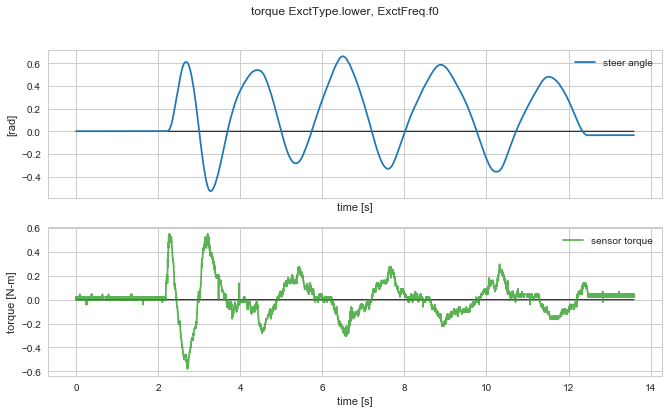

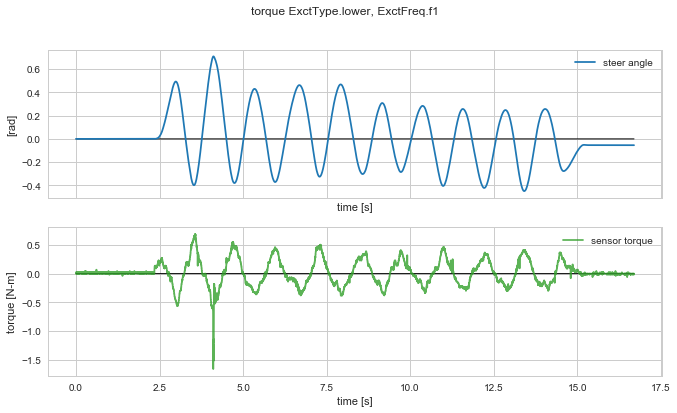

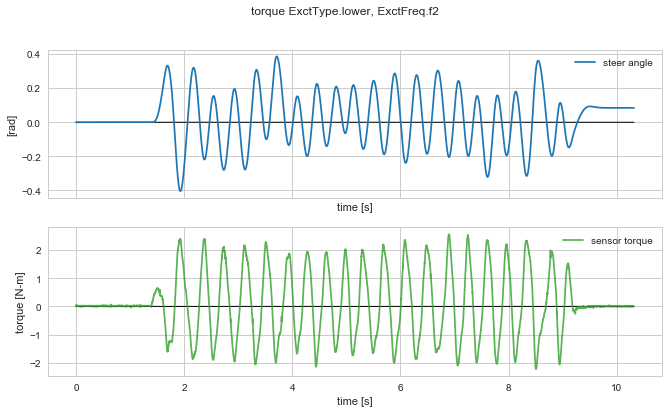

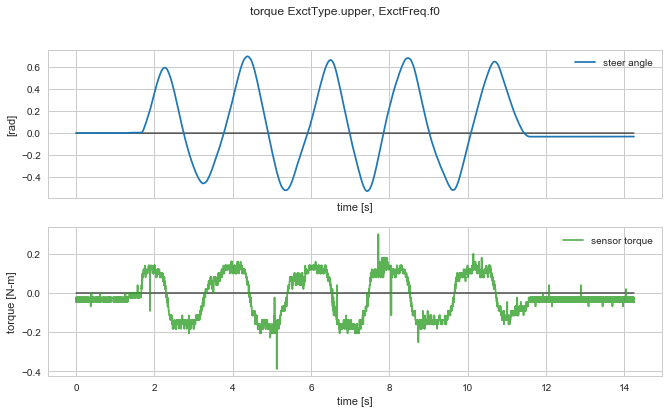

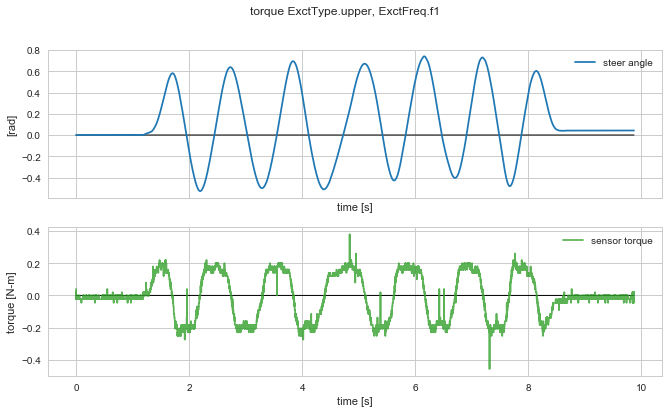

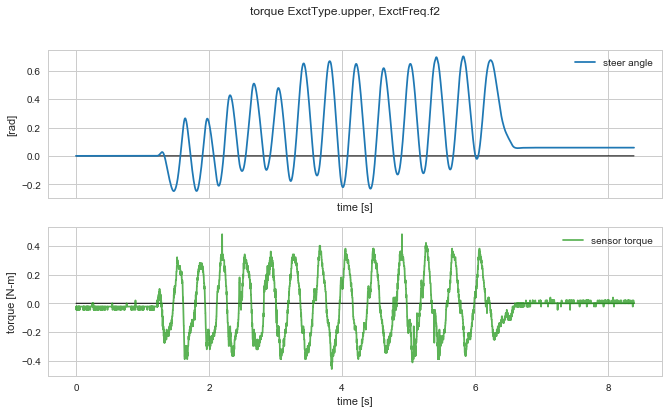

In [7]:
for r in records:
    plot_data(r)

In [8]:
# Estimate inertia, damping of other mass by least squares.
# If excitation is applied to upper assembly, this function
# estimates the inertia and damping of the lower assembly.
# This assumes that the difference in position of the upper
# and lower assembly is negligible.
#
# T = m*x_dd + b*x_d
# T = [x_dd, x_d] [m, b]'

savgol_width = 111
savgol_polyorder = 5

def sg_filter(signal, deriv, delta=0):
    x = scipy.signal.savgol_filter(
        signal, savgol_width, savgol_polyorder,
        deriv=deriv, delta=delta,
        mode='nearest').reshape((-1, 1))
    return x

def estimate_mb(record):
    dt = np.mean(np.diff(record.data.time)[:-1])
    torque = convert_adc_nm(record)
    velocity = sg_filter(record.data.steer_angle, 1, dt)
    acceleration = sg_filter(record.data.steer_angle, 2, dt)
    A = np.hstack((acceleration, velocity))
    return np.squeeze(np.linalg.lstsq(A, torque)[0])

In [9]:
def plot_estimates(record):
    m, b = estimate_mb(record)
    if record.exct_type == ExctType.lower:
        assembly_type = 'upper'
    else:
        assembly_type = 'lower'
    print('record {}, {}'.format(record.exct_type, record.exct_freq))
    print('{} estimated inertia: {}'.format(assembly_type, m))
    print('{} estimated viscous damping: {}'.format(assembly_type, b))
    
    colors = sns.color_palette('Paired', 10)
    fig, ax = plt.subplots(1, 1, figsize=(11, 6), sharex=True)
    dt = np.mean(np.diff(record.data.time)[:-1])
    torque = convert_adc_nm(record)
    veloc = sg_filter(record.data.steer_angle, 1, dt)
    accel = sg_filter(record.data.steer_angle, 2, dt)
    ax.plot(record.data.time, torque, color=colors[3],
            alpha=0.8,
            label='sensor torque')
    ax.plot(record.data.time, m*accel, color=colors[4],
            alpha=0.8,
            label='inertia torque')
    ax.plot(record.data.time, b*veloc, color=colors[6],
            alpha=0.8,
            label='damping torque')
    ax.plot(record.data.time, m*accel + b*veloc, color=colors[8],
            alpha=0.8,
            label='sum inertia and damping torque')
    ax.legend()
    ax.set_xlabel('time [s]')
    ax.set_ylabel('torque [N-m]')
    ax.plot(record.data.time, 0*record.data.time, color='black', linewidth=1, zorder=1)
    plt.show()

record ExctType.lower, ExctFreq.f0
upper estimated inertia: 0.03342716133788664
upper estimated viscous damping: 0.020177033016919296


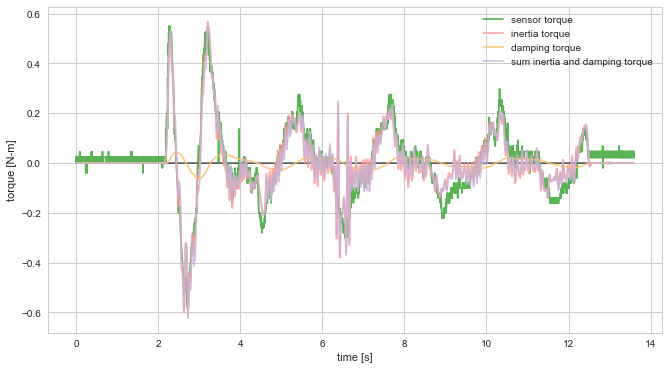

record ExctType.lower, ExctFreq.f1
upper estimated inertia: 0.03294647075099463
upper estimated viscous damping: 0.002137143304095823


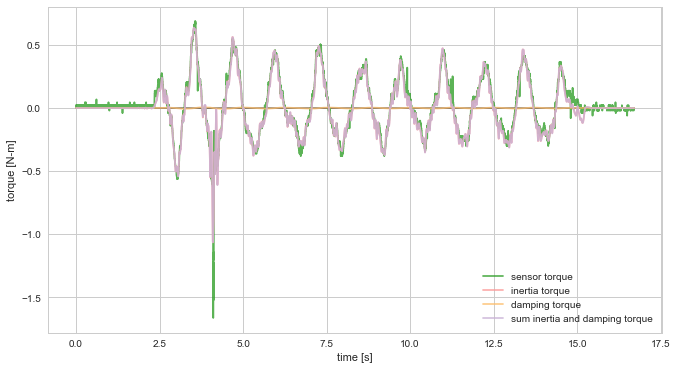

record ExctType.lower, ExctFreq.f2
upper estimated inertia: 0.03164419176107005
upper estimated viscous damping: 0.011803862047518123


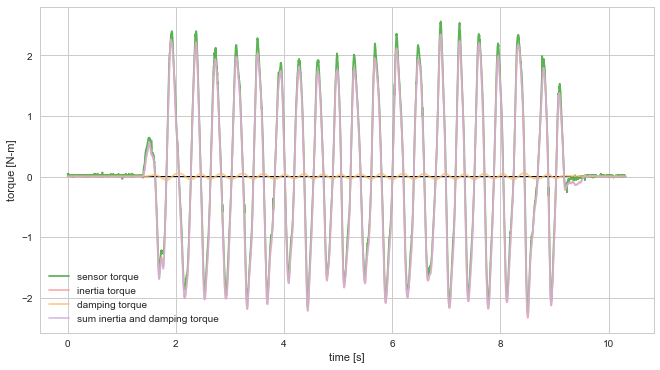

record ExctType.upper, ExctFreq.f0
lower estimated inertia: -0.0035574482735217412
lower estimated viscous damping: 0.09902669577563385


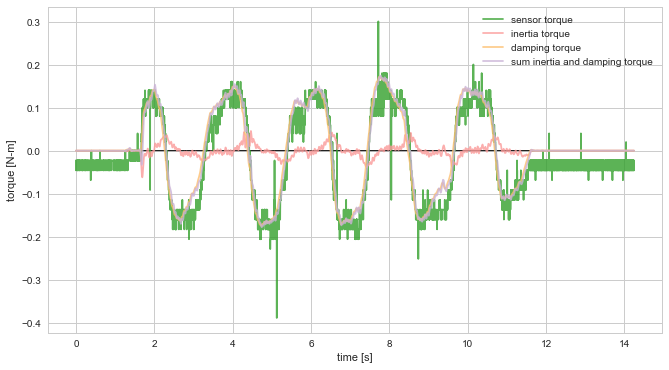

record ExctType.upper, ExctFreq.f1
lower estimated inertia: 0.00040790248530021616
lower estimated viscous damping: 0.06756423749965516


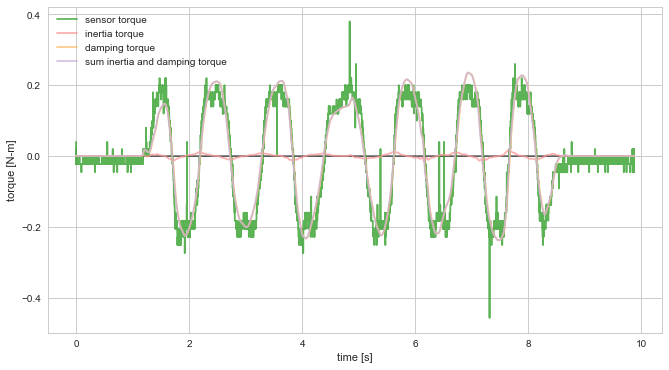

record ExctType.upper, ExctFreq.f2
lower estimated inertia: 0.0022029660872081055
lower estimated viscous damping: 0.03887520062855849


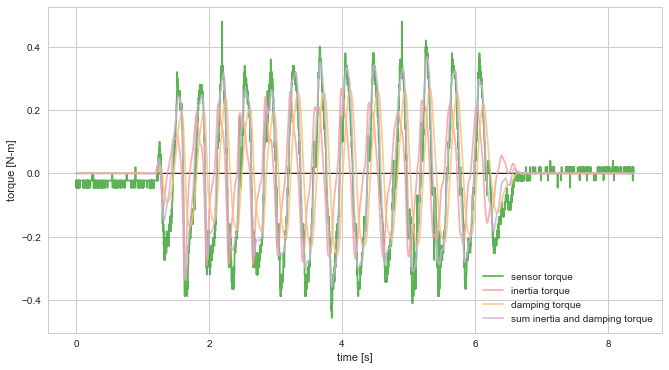

In [10]:
for r in records:
    plot_estimates(r)